# Experiment 3a: Steering at Thought Anchors (KL vs. beta)

This notebook loads:
- an annotated example with a thought anchor,
- the corresponding steering vector computed in `experiments/find_steering_vectors.py`,

and measures how the next-token distribution changes when we steer activations
at the layer and position just before the anchor sentence. We sweep steering amplitude
`beta` in [-1, 1] and compute KL divergence vs. the unsteered baseline.

## Combined Curve + Scatter Helpers (by metric)

Utilities to render a two-panel figure: left = color-coded KL curves vs beta; right = amplitude (|a| from quadratic fit) vs a selected per-chunk metric.

In [ ]:
import os, json, math
from typing import List, Dict

import torch
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append(os.path.abspath(os.path.join(os.path.dirname('__file__'), '..')))
from utils import load_model_and_vectors, split_solution_into_chunks

# optional: use only portion of GPU memory
# torch.cuda.set_per_process_memory_fraction(0.40, device=0)  # notebook only

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

/opt/conda/envs/anchorsteering/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'cuda'

In [26]:
import os, numpy as np, matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from utils import normalize_by_group, normalize_minmax

metric_key_to_label = {
    'kl': 'counterfactual_importance_kl',
    'acc': 'counterfactual_accuracies',
    'diff': 'different_trajectories_fraction',
    'over': 'overdeterminedness',
}

def _get_metric_from_example(ex, idx: int, metric_key: str) -> float:
    arr = ex.get(metric_key_to_label[metric_key], []) or []
    try:
        return float(arr[idx]) if idx < len(arr) else 0.0
    except Exception:
        return 0.0

def _fit_amp_quadratic(xs: np.ndarray, ys: np.ndarray) -> float:
    n = min(xs.size, ys.size)
    if n < 3:
        return np.nan
    try:
        a = float(np.polyfit(xs[:n], ys[:n], 2)[0])
        return abs(a)
    except Exception:
        return np.nan

def _ensure_figdir(p):
    try:
        os.makedirs(p, exist_ok=True)
    except Exception:
        pass

def plot_combined_for_chunk_list(curves: list, examples_list: list, x_values: np.ndarray, metric_key: str, title_prefix: str, save_tag: str = None):
    # Collect metric values aligned to curves
    vals = []
    amps = []
    ex_keys = []
    for c in curves:
        ex_i = int(c.get('example_index', 0))
        ch_i = int(c.get('chunk_index', 0))
        m = _get_metric_from_example(examples_list[ex_i], ch_i, metric_key)
        vals.append(m)
        ex_keys.append(ex_i)
        amps.append(_fit_amp_quadratic(np.asarray(x_values, dtype=float), np.asarray(c.get('ys', []), dtype=float)))
    M = np.asarray(vals, dtype=float)
    A = np.asarray(amps, dtype=float)
    A_norm = np.asarray(normalize_by_group(ex_keys, A), dtype=float)
    vmin, vmax = (0.0, (np.nanmax(M) if np.isfinite(np.nanmax(M)) else 1.0)) if metric_key != 'kl' else (0.0, (np.nanmax(M) if np.isfinite(np.nanmax(M)) else 0.01))
    norm = Normalize(vmin=vmin, vmax=max(vmin+1e-9, vmax))
    cmap = plt.cm.viridis

    fig, axes = plt.subplots(1,2, figsize=(12,5))
    ax0, ax1 = axes

    # Left: curves color-coded
    for c, m in zip(curves, M):
        ys = np.asarray(c.get('ys', []), dtype=float)
        n = min(len(x_values), len(ys))
        if n == 0:
            continue
        ax0.plot(x_values[:n], ys[:n], color=cmap(norm(m)), linewidth=1.4, alpha=0.7)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array(M)
    cb = fig.colorbar(sm, ax=ax0, pad=0.02); cb.set_label(metric_key_to_label[metric_key])
    ax0.set_xlabel('beta (× RMS)'); ax0.set_ylabel('KL(steered || base)')
    ax0.set_title(f'{title_prefix}: KL vs beta (color = {metric_key_to_label[metric_key]})')
    ax0.grid(True, alpha=0.3)

    # Right: amplitude vs metric scatter
    ax1.scatter(M, A_norm, edgecolor='black', alpha=0.7)
    ax1.set_xlabel(metric_key_to_label[metric_key]); ax1.set_ylabel('normalized |a| (per example)')
    ax1.set_title('Amplitude vs metric')
    ax1.grid(True, alpha=0.3)

    plt.tight_layout()
    if save_tag:
        figdir = repo_root / 'generated_data' / 'figures'
        _ensure_figdir(figdir)
        fp = figdir / f'exp3a_{save_tag}_{metric_key}.png'
        try:
            fig.savefig(fp, dpi=200); print(f'Saved: {fp}')
        except Exception as e:
            print('Save failed:', e)
    plt.show()

def plot_combined_for_centered(curves_dict: dict, example: dict, x_values: np.ndarray, metric_key: str, anchor_idx: int = None, title_prefix: str = '', save_tag: str = None):
    # Build arrays aligned to chunk indices
    idxs = sorted(int(k) for k in curves_dict.keys())
    M = np.array([_get_metric_from_example(example, i, metric_key) for i in idxs], dtype=float)
    A = []
    for i in idxs:
        ys = np.asarray(curves_dict.get(i, []) or [], dtype=float)
        A.append(_fit_amp_quadratic(np.asarray(x_values, dtype=float), ys))
    A = np.asarray(A, dtype=float)
    A_norm = np.asarray(normalize_minmax(A), dtype=float)
    vmin, vmax = (0.0, (np.nanmax(M) if np.isfinite(np.nanmax(M)) else 1.0)) if metric_key != 'kl' else (0.0, (np.nanmax(M) if np.isfinite(np.nanmax(M)) else 0.01))
    norm = Normalize(vmin=vmin, vmax=max(vmin+1e-9, vmax))
    cmap = plt.cm.plasma

    fig, axes = plt.subplots(1,2, figsize=(12,5))
    ax0, ax1 = axes
    for i, m in zip(idxs, M):
        ys = np.asarray(curves_dict.get(i, []) or [], dtype=float)
        n = min(len(x_values), len(ys))
        if n == 0:
            continue
        lw = 2.6 if (anchor_idx is not None and i == int(anchor_idx)) else 1.5
        alpha = 0.95 if (anchor_idx is not None and i == int(anchor_idx)) else 0.6
        ax0.plot(x_values[:n], ys[:n], color=cmap(norm(m)), linewidth=lw, alpha=alpha)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array(M)
    cb = fig.colorbar(sm, ax=ax0, pad=0.02); cb.set_label(metric_key_to_label[metric_key])
    ax0.set_xlabel('beta (× RMS)'); ax0.set_ylabel('KL(steered || base)')
    ax0.set_title(f'{title_prefix}: KL vs beta (color = {metric_key_to_label[metric_key]})')
    ax0.grid(True, alpha=0.3)

    ax1.scatter(M, A_norm, edgecolor='black', alpha=0.7)
    ax1.set_xlabel(metric_key_to_label[metric_key]); ax1.set_ylabel('normalized |a| (per example)')
    ax1.set_title('Amplitude vs metric')
    ax1.grid(True, alpha=0.3)
    plt.tight_layout()
    if save_tag:
        figdir = repo_root / 'generated_data' / 'figures'
        _ensure_figdir(figdir)
        fp = figdir / f'exp3a_{save_tag}_{metric_key}.png'
        try:
            fig.savefig(fp, dpi=200); print(f'Saved: {fp}')
        except Exception as e:
            print('Save failed:', e)
    plt.show()



### Combined figures: per-chunk steering (by metric)

For the latent-direction steering (per-chunk vectors), render four figures with two subplots each: KL vs beta colored by a metric, and amplitude vs that metric.

Saved: /home/cutterdawes/SteeringThoughtAnchors/generated_data/figures/exp3a_perchunk_kl_kl.png


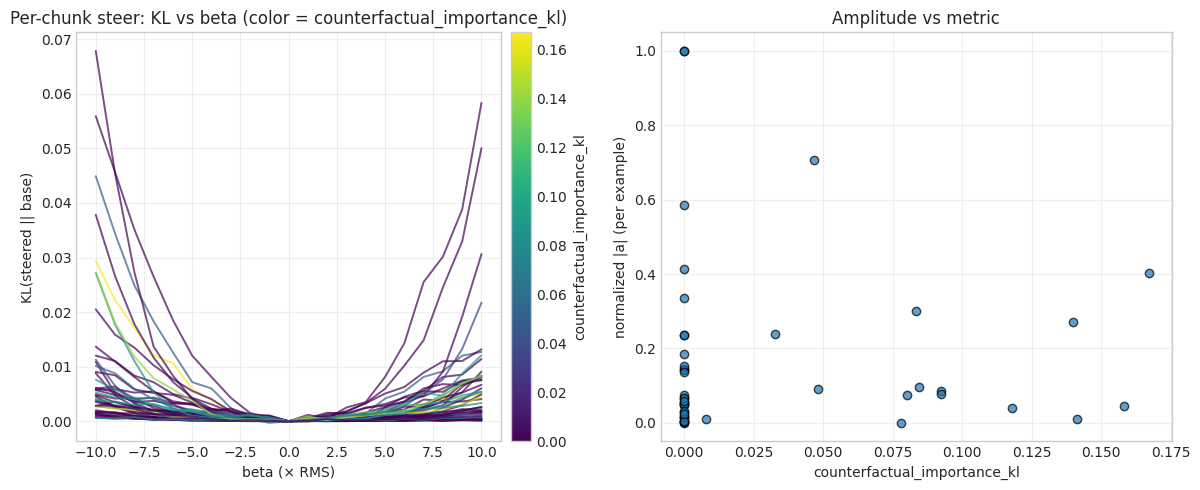

Saved: /home/cutterdawes/SteeringThoughtAnchors/generated_data/figures/exp3a_perchunk_acc_acc.png


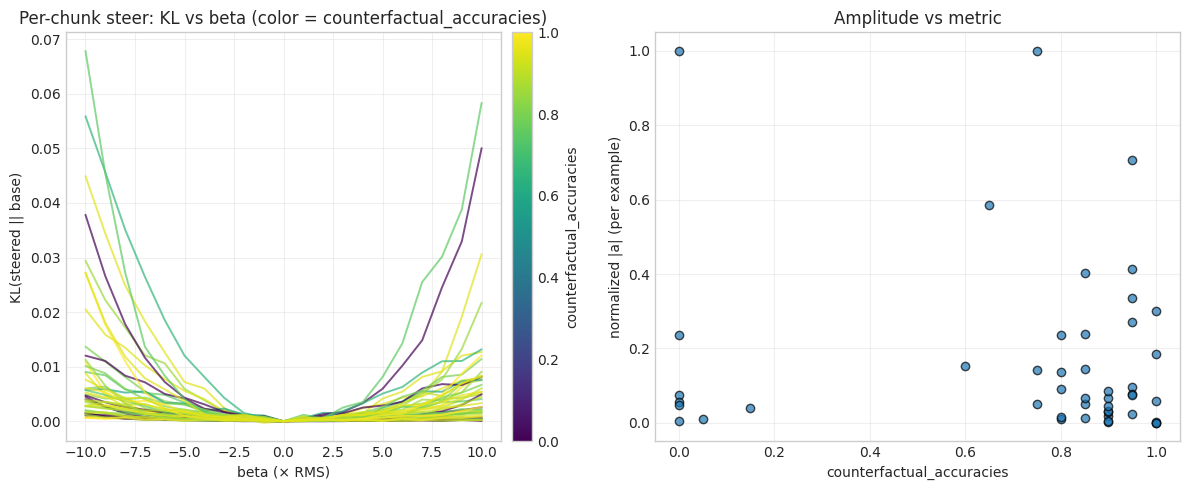

Saved: /home/cutterdawes/SteeringThoughtAnchors/generated_data/figures/exp3a_perchunk_diff_diff.png


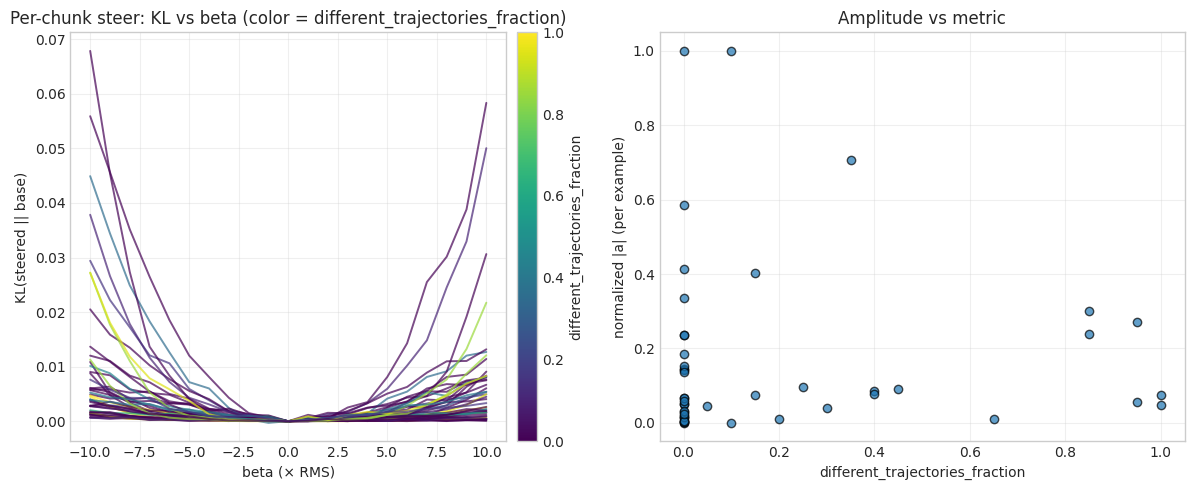

Saved: /home/cutterdawes/SteeringThoughtAnchors/generated_data/figures/exp3a_perchunk_over_over.png


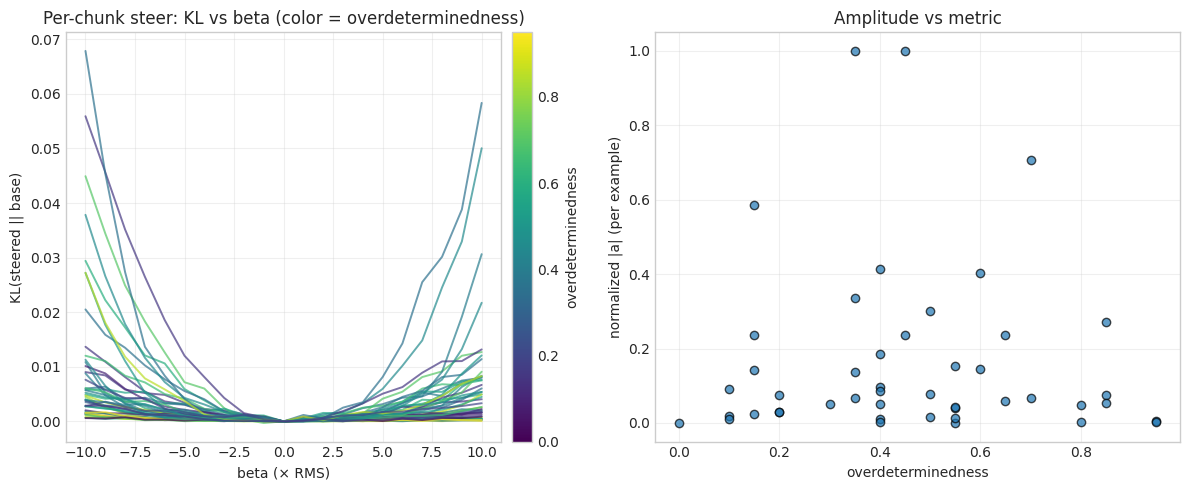

In [27]:
if 'chunk_curves_all' in globals() and chunk_curves_all:
    X = np.asarray(betas, dtype=float)
    for mk in ['kl','acc','diff','over']:
        plot_combined_for_chunk_list(chunk_curves_all, examples, X, mk, 'Per-chunk steer', save_tag=f'perchunk_{mk}')
else:
    print('No per-chunk curves available to plot')


In [5]:
# Config
model_name = 'deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B'
model_tag = model_name.replace('/', '-')
from pathlib import Path
# Find repo root by searching upwards for 'generated_data' (fallback: cwd)
repo_root = Path.cwd().resolve().parents[0] if (Path.cwd()).exists() else Path.cwd().resolve()
# Build absolute paths to the generated_data files
annotated_path = repo_root / 'generated_data' / f'generated_data_annotated_{model_tag}.json'
vectors_path = repo_root / 'generated_data' / f'steering_vectors_{model_tag}.json'
anchors_path = repo_root / 'generated_data' / f'steering_anchors_{model_tag}.json'
max_examples = 8  # subset like 3aii; set None for all
example_index = 0  # change to pick a different example

# Steering amplitudes to test
betas = np.linspace(-10, 10, 21)  # [-1, ..., 1]
betas

array([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,
         1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.])

In [6]:
from pathlib import Path
print('--- Sanity check ---')
names = []
if 'annotated_path' in globals(): names.append(('annotated_path', str(annotated_path)))
if 'anchors_path' in globals(): names.append(('anchors_path', str(anchors_path)))
if 'vectors_path' in globals(): names.append(('vectors_path', str(vectors_path)))
all_ok = True
for nm, p in names:
    ok = Path(p).exists()
    print(f'{nm}:', 'OK' if ok else 'MISSING', p)
    all_ok = all_ok and ok
try:
    from utils import forward_with_logits, kl_from_logits
    print('utils import: OK')
except Exception as e:
    print('utils import failed:', e); all_ok=False
try:
    import torch
    dev = 'cuda' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu')
    print('device:', dev)
except Exception as e:
    print('torch not available:', e)
SANITY_OK = all_ok
print('SANITY_OK =', SANITY_OK)


--- Sanity check ---
annotated_path: OK /home/cutterdawes/SteeringThoughtAnchors/generated_data/generated_data_annotated_deepseek-ai-DeepSeek-R1-Distill-Qwen-1.5B.json
anchors_path: OK /home/cutterdawes/SteeringThoughtAnchors/generated_data/steering_anchors_deepseek-ai-DeepSeek-R1-Distill-Qwen-1.5B.json
vectors_path: OK /home/cutterdawes/SteeringThoughtAnchors/generated_data/steering_vectors_deepseek-ai-DeepSeek-R1-Distill-Qwen-1.5B.json
utils import: OK
device: cuda
SANITY_OK = True


### Combined figures: centered vectors (by metric)

In [7]:
if 'kl_curves_centered' in globals() and isinstance(kl_curves_centered, dict) and kl_curves_centered:
    X = np.asarray(betas, dtype=float)
    for mk in ['kl','acc','diff','over']:
        plot_combined_for_centered(kl_curves_centered, ex, X, mk, anchor_idx=anchor_idx, title_prefix='Centered steer', save_tag=f'centered_{mk}')
else:
    print('No centered curves available to plot')


No centered curves available to plot


In [8]:
# Load model/tokenizer
model, tokenizer, _ = load_model_and_vectors(model_name=model_name, compute_features=False, device=device)
model.model.eval()

# Load data
with open(annotated_path, 'r') as f:
    annotated = json.load(f)
with open(anchors_path, 'r') as f:
    anchors_payload = json.load(f)
len(annotated), len(anchors_payload.get('examples', []))


Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


No mean vectors found for deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B. You can save to generated_data/mean_vectors_deepseek-r1-distill-qwen-1.5b.pt.


(8, 2)

### Combined figures: global diff-in-means (by metric)

In [9]:
if 'chunk_curves_globalvec' in globals() and chunk_curves_globalvec:
    X = np.asarray(betas, dtype=float)
    for mk in ['kl','acc','diff','over']:
        plot_combined_for_chunk_list(chunk_curves_globalvec, examples, X, mk, 'Global diff-in-means', save_tag=f'globaldiff_{mk}')
else:
    print('No global diff-in-means curves available to plot')


No global diff-in-means curves available to plot


In [10]:
# Select example and load per-chunk steering vectors
ex = None
if example_index < len(annotated):
    ex = annotated[example_index]
else:
    ex = annotated[0]

question = ex['prompt']
cot = ex['cot']
anchor_idx = ex.get('thought_anchor_idx', None)
anchor_sentence = ex.get('thought_anchor_sentence', '')

# Load chunk vectors for the matching example from anchors payload
examples_anchors = anchors_payload.get('examples', [])
# Match anchors example by prompt prefix to avoid index mismatches
anchors_ex = {}
if examples_anchors:
    pref = (question or '')[:80].replace('\n',' ')
    for aex in examples_anchors:
        ap = (aex.get('prompt','') or '')[:80].replace('\n',' ')
        if ap == pref:
            anchors_ex = aex; break
    if not anchors_ex: anchors_ex = examples_anchors[min(example_index, len(examples_anchors)-1)]
layer_idx = anchors_ex.get('layer', model.config.num_hidden_layers - 1)

# Build a mapping: chunk_index -> vector tensor
chunk_vectors = {}
for ch in anchors_ex.get('chunks', []):
    vec = torch.tensor(ch.get('vector', []), dtype=(torch.bfloat16 if model.model.dtype==torch.bfloat16 else torch.float32), device=device)
    chunk_vectors[int(ch.get('chunk_index', 0))] = vec

# Validate anchors vs current chunk split; recompute if misaligned
try:
    from utils import split_solution_into_chunks as _split
    chunks = _split(cot)
except Exception:
    import re
    chunks = [p.strip() for p in re.split(r'(?<=[\.\!\?])\s+|\n\n+', cot) if p.strip()]
def _need_recompute():
    try:
        if len(chunks) == 0:
            return False
        idxs = {int(ch.get('chunk_index', 0)) for ch in anchors_ex.get('chunks', [])}
        if len(idxs) < len(chunks):
            return True
        for i, ch in enumerate(anchors_ex.get('chunks', [])[:min(3, len(chunks))]):
            t = (ch.get('text', '') or '').strip()
            if t and (t[:40] != chunks[i][:40]):
                return True
        return False
    except Exception:
        return False

if _need_recompute():
    try:
        from experiments.find_steering_anchors import compute_chunk_vectors_for_example as _compute_vecs
        res = _compute_vecs(model, tokenizer, ex, layer_idx=int(layer_idx), device=device)
        if res and res.get('chunks'):
            chunk_vectors = {}
            for ch in res['chunks']:
                vec = torch.tensor(ch.get('vector', []), dtype=(torch.bfloat16 if model.model.dtype==torch.bfloat16 else torch.float32), device=device)
                chunk_vectors[int(ch.get('chunk_index', 0))] = vec
    except Exception as _e:
        pass
# Default steer_vector: use the anchor's chunk vector if present, else chunk 0
steer_vector = chunk_vectors.get(int(anchor_idx) if anchor_idx is not None else 0, next(iter(chunk_vectors.values()), torch.zeros(model.config.hidden_size, dtype=torch.float32, device=device)))
len(chunk_vectors), layer_idx, anchor_idx, anchor_sentence[:80] + ('...' if len(anchor_sentence)>80 else '')



(25,
 24,
 2,
 'I remember that arithmetic sequences have a common difference between consecutiv...')

In [11]:
# Build the prefix up to (but not including) the anchor sentence
chunks = split_solution_into_chunks(cot)
if anchor_idx is None or anchor_idx < 0 or anchor_idx >= len(chunks):
    # fallback: find sentence match
    try:
        anchor_idx = next((i for i,s in enumerate(chunks) if s.strip()==anchor_sentence.strip()), 0)
    except Exception:
        anchor_idx = 0
prefix_text = '\n'.join(chunks[:anchor_idx])

prompt = (
    "Solve the following problem step by step. You MUST put your final answer in \\boxed{}.\n\n"
    f"Problem: {question}\n\n"
    f"Solution:\n<think>\n{prefix_text}"
)
ids = tokenizer(prompt, return_tensors='pt')
input_ids = ids['input_ids'].to(device)
pad_id = tokenizer.pad_token_id if tokenizer.pad_token_id is not None else (tokenizer.eos_token_id or 0)
attention_mask = (input_ids != pad_id).long().to(device)
input_ids.shape, attention_mask.shape, input_ids[0, -5:]

(torch.Size([1, 101]),
 torch.Size([1, 101]),
 tensor([  624, 80022,    11, 16910,    13], device='cuda:0'))

In [12]:
from utils import forward_with_logits as _fw

@torch.no_grad()
def _forward_with_logits(input_ids, attention_mask):
    # thin wrapper to use shared utils implementation
    return _fw(model, input_ids=input_ids, attention_mask=attention_mask)



In [13]:
# Measurement mode toggle
teacher_forced_mode = True  # compare logits at same positions (teacher-forced)

In [14]:
from utils import logits_with_steer_full as _steer_full

@torch.no_grad()
def logits_with_steer_full(input_ids: torch.Tensor, attention_mask: torch.Tensor, beta: float, target_pos: int):
    return _steer_full(model, input_ids=input_ids, attention_mask=attention_mask, beta=float(beta), layer_idx=int(layer_idx), steer_vec=steer_vector, target_pos=int(target_pos))


In [15]:
from utils import find_chunk_start_token as _find_span, forward_with_logits as _fw, kl_from_logits as _kl, logits_with_steer_full as _steer_full

def kl_curve_for_chunk(chunk_index: int, betas):
    idx = int(chunk_index)
    # Determine steer vector: prefer per-chunk when enabled, else global, else anchors
    use_chunk = globals().get('USE_CHUNK_VECTORS', True)
    v = None
    try:
        if use_chunk and 'chunk_vectors' in globals() and idx in chunk_vectors:
            v = chunk_vectors[idx].detach().to(torch.float32)
    except Exception:
        v = None
    if v is None:
        try:
            if 'steer_vector' in globals() and steer_vector is not None:
                v = steer_vector.detach().to(torch.float32)
        except Exception:
            v = None
    if v is None:
        try:
            vec_by_idx = {int(ch.get('chunk_index',0)): ch.get('vector', []) for ch in anchors_ex.get('chunks', [])}
            v = torch.tensor(vec_by_idx.get(idx, []), dtype=torch.float32, device=device)
        except Exception:
            v = torch.zeros(model.config.hidden_size, dtype=torch.float32, device=device)
# Prepare texts
    prefix_text = '\n'.join(chunks[:idx])
    chunk_text = chunks[idx] if idx < len(chunks) else ''
    ids_pref, am_pref, ids_full, am_full, s_idx, n_steps = _find_span(tokenizer, question, prefix_text, chunk_text, device)
    logits_full = _fw(model, input_ids=ids_full, attention_mask=am_full)
    seq_len = int(logits_full.shape[1])
    start = max(0, int(s_idx) - 1)
    n_eff = max(0, min(int(n_steps), int(seq_len - start)))
    if n_eff == 0:
        return []
    base_steps = logits_full[:, start:start+n_eff, :]
    base_avg = base_steps.mean(dim=1)
    y_curve = []
    for b in betas:
        if abs(float(b)) < 1e-12:
            y_curve.append(0.0)
            continue
        logs = _steer_full(model, input_ids=ids_full, attention_mask=am_full, beta=float(b), layer_idx=int(layer_idx), steer_vec=v, target_pos=int(start))
        steered_span = logs[:, start:start+n_eff, :]
        kl_t = _kl(steered_span.reshape(-1, steered_span.shape[-1]), base_slice.reshape(-1, base_slice.shape[-1]))
        y_curve.append(float(kl_t.mean().item()))
    return y_curve





In [16]:
from utils import compute_kl_curve_for_chunk


In [17]:
# Multi-example KL curves (mirror 3aii)
# Build subset of examples
examples = annotated
# Prefer examples with an anchor sentence
examples = [ex for ex in examples if ex.get('thought_anchor_sentence')]
if max_examples is not None:
    examples = examples[:int(max_examples)]

# Storage like 3aii (flat list of chunk curves)
chunk_curves_all = []

# Iterate examples and chunks; for each example, load its per-chunk vectors and layer
examples_anchors = anchors_payload.get('examples', [])
for ex_i, ex in enumerate(examples):
    # Guard against anchors length mismatch
    if ex_i >= len(examples_anchors):
        break
    # Match anchors example by prompt prefix
    anchors_ex = {}
    if examples_anchors:
        pref = (question or '')[:80].replace('\n',' ')
        for aex in examples_anchors:
            ap = (aex.get('prompt','') or '')[:80].replace('\n',' ')
            if ap == pref:
                anchors_ex = aex; break
        if not anchors_ex: anchors_ex = examples_anchors[min(ex_i, len(examples_anchors)-1)]
    layer_idx = anchors_ex.get('layer', model.config.num_hidden_layers - 1)
    # Create chunk vectors mapping for this example
    chunk_vectors = {}
    for ch in anchors_ex.get('chunks', []):
        vec = torch.tensor(ch.get('vector', []), dtype=(torch.bfloat16 if model.model.dtype==torch.bfloat16 else torch.float32), device=device)
        chunk_vectors[int(ch.get('chunk_index', 0))] = vec
    # Skip if no vectors
    if not chunk_vectors:
        continue
    # Prepare question/chunks globals used by kl_curve_for_chunk
    question = ex.get('prompt', '')
    cot_text = ex.get('cot') or ''
    try:
        chunks = split_solution_into_chunks(cot_text)
    except Exception:
        import re
        chunks = [p.strip() for p in re.split(r'(?<=[\.\!\?])\s+|\n\n+', cot_text) if p.strip()]
    if not chunks:
        continue
    # Compute per-chunk KL curves using the example's vectors
    for idx in range(len(chunks)):
        curve = compute_kl_curve_for_chunk(model, tokenizer, ex, anchors_ex, layer_idx=int(layer_idx), betas=betas, device=device, chunk_index=int(idx))
        if not curve:
            continue
        # Importance per chunk (mirror 3aii's counterfactual_importance_kl)
        try:
            imp = float(ex.get('counterfactual_importance_kl', [0.0]*len(chunks))[idx])
        except Exception:
            imp = 0.0
        chunk_curves_all.append({
            'example_index': ex_i,
            'chunk_index': idx,
            'importance': imp,
            'ys': list(map(float, curve)),
        })
len(chunk_curves_all)




46

In [18]:
# Compute KL for the anchor using the exact same implementation as the per-chunk routine
# This calls kl_curve_for_chunk which conditions the base logits on the ground-truth chunk
# and performs the identical free-running steered rollout used for other chunks.
kl_values = compute_kl_curve_for_chunk(model, tokenizer, ex, anchors_ex, layer_idx=int(layer_idx), betas=betas, device=device, chunk_index=int(anchor_idx))
kl_values


[0.0016632080078125,
 0.00135040283203125,
 0.00128936767578125,
 0.000732421875,
 0.000728607177734375,
 0.00075531005859375,
 0.00072479248046875,
 0.0004730224609375,
 0.0002117156982421875,
 -9.1552734375e-05,
 0.0,
 0.000217437744140625,
 -3.552436828613281e-05,
 0.00063323974609375,
 0.001129150390625,
 0.0022430419921875,
 0.004150390625,
 0.005279541015625,
 0.00848388671875,
 0.01123046875,
 0.01953125]

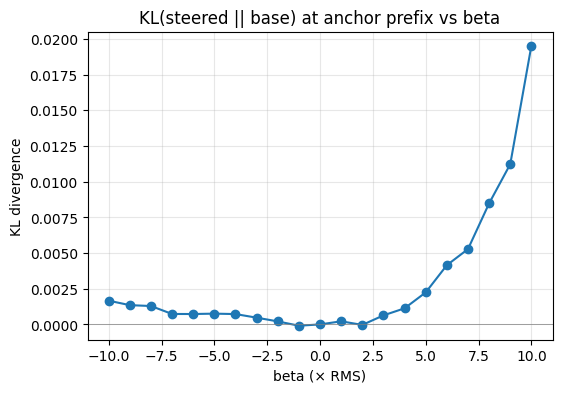

In [19]:
plt.figure(figsize=(6,4))
plt.plot(betas, kl_values, marker='o')
plt.axhline(0, color='gray', lw=0.5)
plt.title('KL(steered || base) at anchor prefix vs beta')
plt.xlabel('beta (× RMS)')
plt.ylabel('KL divergence')
plt.grid(True, alpha=0.3)
plt.show()


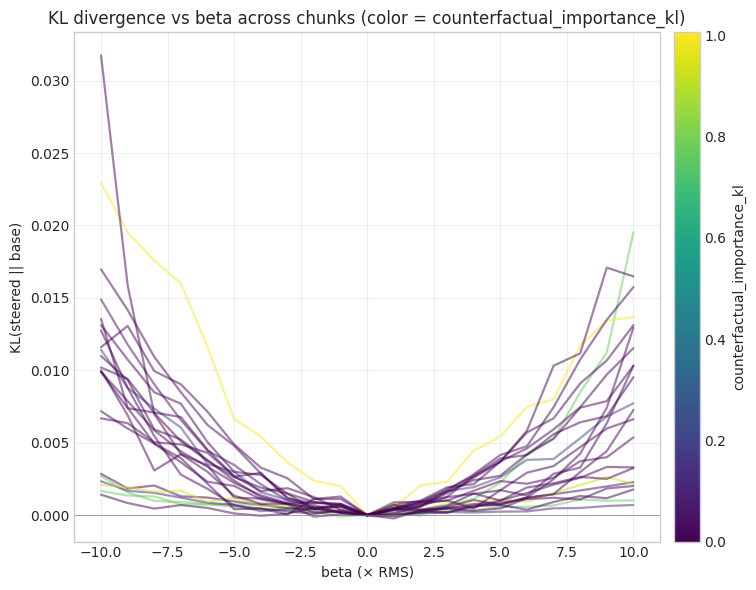

In [20]:
# Compute KL curves for all chunks and plot, color-coded by counterfactual_importance_kl with a colorbar
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import viridis
plt.style.use('seaborn-v0_8-whitegrid')

# Ensure kl_curves exists and has entries
kl_curves = {} if 'kl_curves' not in globals() else kl_curves
if not kl_curves:
    kl_curves = {}
    for idx in range(len(chunks)):
        kl_curves[idx] = compute_kl_curve_for_chunk(model, tokenizer, ex, anchors_ex, layer_idx=int(layer_idx), betas=betas, device=device, chunk_index=int(idx))

# Build importance array aligned to chunk indices (use 0.0 when missing)
raw_imps = []
for i in range(len(chunks)):
    try:
        raw_imps.append(float(ex['counterfactual_importance_kl'][i]))
    except Exception:
        raw_imps.append(0.0)
imps = np.array(raw_imps, dtype=float)

# Normalizer and colormap
imp_min = float(np.nanmin(imps)) if imps.size>0 else 0.0
imp_max = float(np.nanmax(imps)) if imps.size>0 else 1.0
if imp_max <= imp_min:
    imp_max = imp_min + 1e-6
norm = Normalize(vmin=imp_min, vmax=imp_max)
cmap = plt.cm.viridis

# Plot each chunk's KL curve colored by its importance
fig, ax = plt.subplots(figsize=(8,6))
for idx in sorted(kl_curves.keys()):
    vals = kl_curves[idx]
    if vals is None or len(vals)==0:
        continue
    ys = np.array(vals, dtype=float)
    # If lengths mismatch, trim/pad to betas length
    n = min(len(ys), len(betas))
    xs = np.array(betas)[:n]
    ys = ys[:n]
    col = cmap(norm(imps[idx] if idx < len(imps) else 0.0))
    lw = 1.6  # 2.8 if idx == anchor_idx else 1.6
    alpha = 0.5  # = 0.95 if idx == anchor_idx else 0.6
    ax.plot(xs, ys, color=col, linewidth=lw, alpha=alpha)

# Colorbar mapped to counterfactual_importance_kl
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array(imps)
cbar = fig.colorbar(sm, ax=ax, pad=0.02)
cbar.set_label('counterfactual_importance_kl')

# Labels and styling
ax.axhline(0, color='gray', lw=0.5)
ax.set_xlabel('beta (× RMS)')
ax.set_ylabel('KL(steered || base)')
ax.set_title('KL divergence vs beta across chunks (color = counterfactual_importance_kl)')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


n_points=46, spearman_rho=0.11636988624651659, pval=0.4412048651497391, slope=-1.7838887211032486e-05, intercept=8.579200886136682e-05


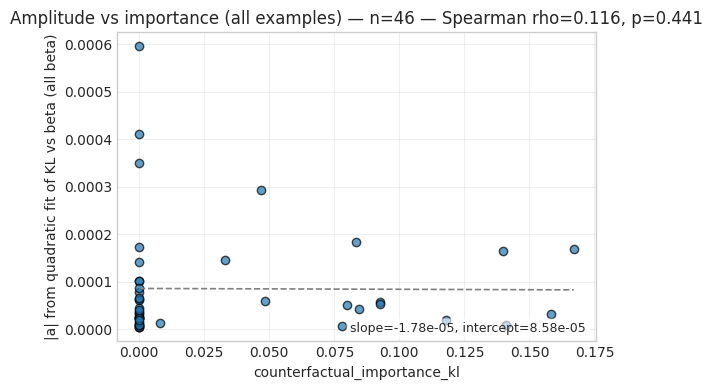

In [21]:
# Fit a quadratic to each KL curve (all beta) across examples and plot amplitude vs counterfactual_importance_kl
import numpy as np
import matplotlib.pyplot as plt
# Try SciPy for Spearman; fallback to rank+pearson if not available
try:
    from scipy.stats import spearmanr
    _have_scipy = True
except Exception:
    _have_scipy = False

eps_floats = np.array([float(e) for e in betas])
amplitudes = []
importances = []

for c in chunk_curves_all:
    ys = np.array(c.get('ys', []), dtype=float)
    if ys.size == 0:
        continue
    n = min(len(ys), len(eps_floats))
    x = eps_floats[:n]
    y = ys[:n]
    if x.size < 3 or np.all(np.isnan(y)):
        continue
    try:
        coeffs = np.polyfit(x, y, 2)  # [a, b, c]
        a = float(coeffs[0]); amp = float(np.abs(a))
    except Exception:
        continue
    amplitudes.append(amp)
    importances.append(float(c.get('importance', 0.0)))

x = np.array(importances)
y = np.array(amplitudes)
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(x, y, edgecolor='black', alpha=0.7)
ax.set_xlabel('counterfactual_importance_kl')
ax.set_ylabel('|a| from quadratic fit of KL vs beta (all beta)')

rho, pval = np.nan, np.nan
n_points = x.size
if n_points > 1:
    if _have_scipy:
        try:
            rho, pval = spearmanr(x, y)
        except Exception:
            rho, pval = np.nan, np.nan
    else:
        def _ranks(arr):
            order = np.argsort(arr)
            ranks = np.empty_like(order, dtype=float)
            ranks[order] = np.arange(len(arr), dtype=float)
            return ranks
        try:
            rx = _ranks(x); ry = _ranks(y)
            if np.nanstd(rx) == 0 or np.nanstd(ry) == 0:
                rho, pval = np.nan, np.nan
            else:
                rho = float(np.corrcoef(rx, ry)[0,1]); pval = np.nan
        except Exception:
            rho, pval = np.nan, np.nan

slope, intercept = np.nan, np.nan
if n_points > 1 and not np.allclose(x, x[0]):
    try:
        slope, intercept = np.polyfit(x, y, 1)
        xs_line = np.linspace(np.nanmin(x), np.nanmax(x), 200)
        ys_line = slope * xs_line + intercept
        ax.plot(xs_line, ys_line, color='gray', linestyle='--', linewidth=1.2, label=f'best-fit (slope={slope:.3g})')
    except Exception:
        slope, intercept = np.nan, np.nan

title = f'Amplitude vs importance (all examples) — n={n_points} — Spearman rho={np.nan if np.isnan(rho) else float(rho):.3f}'
if not np.isnan(pval):
    title += f', p={float(pval):.3g}'
ax.set_title(title)
if not np.isnan(slope) or not np.isnan(intercept):
    ax.text(0.98, 0.02, f'slope={slope:.3g}, intercept={intercept:.3g}', transform=ax.transAxes, 
            ha='right', va='bottom', fontsize=9,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.6, edgecolor='none'))
print(f'n_points={n_points}, spearman_rho={rho}, pval={pval}, slope={slope}, intercept={intercept}')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Centered Steering: Chunk − Mean(Others)

We now steer using a centered direction for each chunk: v_i = unit( z_i − mean_{j≠i} z_j ),
where z_i is the per-chunk mean activation vector from `steering_anchors`.
This removes the global common component across chunks and may sharpen cluster-specific effects.


In [22]:
# Ensure per-chunk vectors are used for centered steering
USE_CHUNK_VECTORS = True
# Build centered (difference) vectors per chunk: v_i = unit(z_i − mean_{j≠i} z_j)
diff_chunk_vectors = {}
all_idxs = sorted(chunk_vectors.keys())
all_vecs = {i: chunk_vectors[i].detach().to(torch.float32) for i in all_idxs}
stack = torch.stack([all_vecs[i] for i in all_idxs], dim=0) if len(all_idxs) > 0 else torch.empty((0, model.config.hidden_size), dtype=torch.float32, device=device)
for i in all_idxs:
    if len(all_idxs) > 1:
        mean_others = (stack.sum(dim=0) - all_vecs[i]) / (len(all_idxs) - 1)
    else:
        mean_others = torch.zeros_like(all_vecs[i])
    diff = all_vecs[i] - mean_others
    diff = diff / (diff.norm() + 1e-12)
    diff_chunk_vectors[i] = diff.to(device=chunk_vectors[i].device, dtype=chunk_vectors[i].dtype)

# Use centered vectors to recompute KL curves (anchor + all chunks), preserving original vectors
chunk_vectors_orig = chunk_vectors
chunk_vectors = diff_chunk_vectors

# Anchor-only curve (teacher_forced_mode honored)
kl_values_centered = kl_curve_for_chunk(anchor_idx, betas)
plt.figure(figsize=(6,4))
plt.plot(betas, kl_values_centered, marker='o')
plt.axhline(0, color='gray', lw=0.5)
plt.title('KL(steered || base) at anchor prefix vs beta — centered vector')
plt.xlabel('beta (× RMS)'); plt.ylabel('KL divergence')
plt.grid(True, alpha=0.3)
plt.show()

# All-chunk curves colored by counterfactual_importance_kl (anchor highlighted)
from matplotlib.colors import Normalize
plt.style.use('seaborn-v0_8-whitegrid')
# Compute centered KL curves
kl_curves_centered = {}
for idx in range(len(chunks)):
    kl_curves_centered[idx] = kl_curve_for_chunk(idx, betas)

# Build importance array aligned to chunk indices (use 0.0 when missing)
raw_imps_centered = []
for i in range(len(chunks)):
    try:
        raw_imps_centered.append(float(ex['counterfactual_importance_kl'][i]))
    except Exception:
        raw_imps_centered.append(0.0)
imps_centered = np.array(raw_imps_centered, dtype=float)
imp_min = float(np.nanmin(imps_centered)) if imps_centered.size>0 else 0.0
imp_max = float(np.nanmax(imps_centered)) if imps_centered.size>0 else 1.0
if imp_max <= imp_min:
    imp_max = imp_min + 1e-6
norm = Normalize(vmin=imp_min, vmax=imp_max)
cmap = plt.cm.viridis

fig, ax = plt.subplots(figsize=(8,6))
for idx in sorted(kl_curves_centered.keys()):
    vals = kl_curves_centered[idx]
    if vals is None or len(vals)==0:
        continue
    ys = np.array(vals, dtype=float)
    n = min(len(ys), len(betas))
    xs = np.array(betas)[:n]
    ys = ys[:n]
    col = cmap(norm(imps_centered[idx] if idx < len(imps_centered) else 0.0))
    lw = 2.8 if idx == anchor_idx else 1.6
    alpha = 0.95 if idx == anchor_idx else 0.5
    label = 'anchor' if idx == anchor_idx else None
    ax.plot(xs, ys, color=col, linewidth=lw, alpha=alpha, label=label)

# Colorbar mapped to counterfactual_importance_kl
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array(imps_centered)
cbar = fig.colorbar(sm, ax=ax, pad=0.02)
cbar.set_label('counterfactual_importance_kl')

ax.axhline(0, color='gray', lw=0.5)
ax.set_xlabel('beta (× RMS)')
ax.set_ylabel('KL(steered || base)')
ax.set_title('KL vs beta across chunks — centered vector (color = counterfactual_importance_kl)')
ax.legend(ncol=2, fontsize=8)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Restore original chunk vectors
chunk_vectors = chunk_vectors_orig


NameError: name 'base_slice' is not defined

n_points=22, spearman_rho=-0.26258113654505244, pval=0.2377693953525288, slope=-2.4322680057823475e-05, intercept=4.6181366443896634e-05


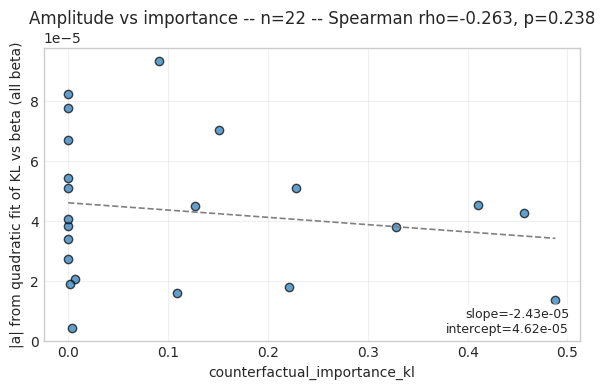

In [ ]:
import numpy as np
from scipy.stats import spearmanr
from scipy.stats import spearmanr

# Fit quadratics to kl_curves_centered and scatter amplitude vs counterfactual_importance_kl
import matplotlib.pyplot as plt

# SciPy Spearman fallback handling (try reuse _have_scipy if present)
try:
    _have_scipy
except NameError:
    try:
        _have_scipy = True
    except Exception:
        _have_scipy = False

import numpy as np
import matplotlib.pyplot as plt
# Try SciPy for Spearman; fallback to rank+pearson if not available
try:
    from scipy.stats import spearmanr
    _have_scipy = True
except Exception:
    _have_scipy = False

eps_floats = np.array([float(e) for e in betas])
amplitudes = []
importances = []
for idx in range(len(chunks)):
    curve = kl_curves_centered.get(idx, None)
    if curve is None or len(curve) == 0:
        continue
    ys = np.array(curve, dtype=float)
    n = min(len(ys), len(eps_floats))
    x = eps_floats[:n]
    y = ys[:n]
    # Need at least 3 points to fit a quadratic robustly
    if x.size < 3 or np.all(np.isnan(y)):
        continue
    try:
        coeffs = np.polyfit(x, y, 2)  # returns [a, b, c]
        a = float(coeffs[0])
        amp = float(np.abs(a))
    except Exception:
        continue
    amplitudes.append(amp)
    # safe importance retrieval (fallback 0.0)
    try:
        imp = float(ex.get('counterfactual_importance_kl', [0.0]*len(chunks))[idx])
    except Exception:
        imp = 0.0
    importances.append(imp)

# Convert to arrays for plotting/statistics
x = np.array(importances)
y = np.array(amplitudes)

fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(x, y, edgecolor='black', alpha=0.7)
ax.set_xlabel('counterfactual_importance_kl')
ax.set_ylabel('|a| from quadratic fit of KL vs beta (all beta)')

# Compute Spearman if available and meaningful
rho, pval = np.nan, np.nan
n_points = x.size
if n_points > 1:
    if _have_scipy:
        try:
            rho, pval = spearmanr(x, y)
        except Exception:
            rho, pval = np.nan, np.nan
    else:
        # fallback: compute ranks and Pearson on ranks
        def _ranks(arr):
            order = np.argsort(arr)
            ranks = np.empty_like(order, dtype=float)
            ranks[order] = np.arange(len(arr), dtype=float)
            return ranks
        try:
            rx = _ranks(x)
            ry = _ranks(y)
            if np.nanstd(rx) == 0 or np.nanstd(ry) == 0:
                rho, pval = np.nan, np.nan
            else:
                rho = float(np.corrcoef(rx, ry)[0,1])
                pval = np.nan
        except Exception:
            rho, pval = np.nan, np.nan

# Best-fit linear regression on (importance -> amplitude) for visualization
slope, intercept = np.nan, np.nan
if n_points > 1 and not np.allclose(x, x[0]):
    try:
        slope, intercept = np.polyfit(x, y, 1)
        xs_line = np.linspace(np.nanmin(x), np.nanmax(x), 200)
        ys_line = slope * xs_line + intercept
        ax.plot(xs_line, ys_line, color='gray', linestyle='--', linewidth=1.2, label=f'best-fit (slope={slope:.3g})')
    except Exception:
        slope, intercept = np.nan, np.nan

# Title and annotation
title = f'Amplitude vs importance -- n={n_points} -- Spearman rho={np.nan if np.isnan(rho) else float(rho):.3f}'
if not np.isnan(pval):
    title += f', p={float(pval):.3g}'
ax.set_title(title)
# Put fit stats on the plot
ann_lines = []
if not np.isnan(slope):
    ann_lines.append(f'slope={slope:.3g}')
if not np.isnan(intercept):
    ann_lines.append(f'intercept={intercept:.3g}')
if ann_lines:
    ax.text(0.98, 0.02, '\n'.join(ann_lines), transform=ax.transAxes, ha='right', va='bottom', fontsize=9,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.6, edgecolor='none'))

# Print summary stats to the output as well
print(f'n_points={n_points}, spearman_rho={rho}, pval={pval}, slope={slope}, intercept={intercept}')

ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Global Difference-in-Means Steering (single vector for all chunks)

We compute a single latent direction by taking the difference between the mean of chunks with counterfactual_importance_kl above a threshold and the mean of the rest. We then steer every chunk by this single vector and: (i) plot KL vs beta across chunks, and (ii) scatter the importance vs the fitted quadratic amplitude.

In [ ]:

# Global difference-in-means steering vector across examples/chunks
# Threshold separates meaningfully non-zero counterfactual_importance_kl values
cf_importance_threshold = 0.2  # adjust as needed

examples = [ex for ex in annotated if ex.get('thought_anchor_sentence')]
if max_examples is not None:
    examples = examples[:int(max_examples)]
examples_anchors = anchors_payload.get('examples', [])

pos_vecs = []
neg_vecs = []
all_hidden_size = getattr(model.config, 'hidden_size', None) or getattr(model.config, 'n_embd', None)

for ex_i, ex in enumerate(examples):
    if ex_i >= len(examples_anchors):
        break
    anchors_ex = examples_anchors[ex_i] or {}
    imp_list = ex.get('counterfactual_importance_kl', [])
    for ch in anchors_ex.get('chunks', []):
        idx = int(ch.get('chunk_index', 0))
        vec = torch.tensor(ch.get('vector', []), dtype=torch.float32, device=device)
        imp = float(imp_list[idx]) if idx < len(imp_list) else 0.0
        if imp >= cf_importance_threshold:
            pos_vecs.append(vec)
        else:
            neg_vecs.append(vec)

# Compute difference-in-means vector
if pos_vecs and neg_vecs:
    m_pos = torch.stack(pos_vecs, dim=0).mean(dim=0)
    m_neg = torch.stack(neg_vecs, dim=0).mean(dim=0)
    global_steer_vector = (m_pos - m_neg)
elif pos_vecs and not neg_vecs:
    m_pos = torch.stack(pos_vecs, dim=0).mean(dim=0)
    global_steer_vector = m_pos
elif neg_vecs and not pos_vecs:
    m_neg = torch.stack(neg_vecs, dim=0).mean(dim=0)
    global_steer_vector = -m_neg
else:
    # Fallback: zero vector
    global_steer_vector = torch.zeros(all_hidden_size, dtype=torch.float32, device=device)

# Unit normalize
norm = global_steer_vector.norm() + 1e-12
global_steer_vector = (global_steer_vector / norm).to(device=device, dtype=(torch.bfloat16 if getattr(model.model, 'dtype', torch.float32)==torch.bfloat16 else torch.float32))

global_steer_vector.shape, len(pos_vecs), len(neg_vecs)

(torch.Size([1536]), 11, 35)

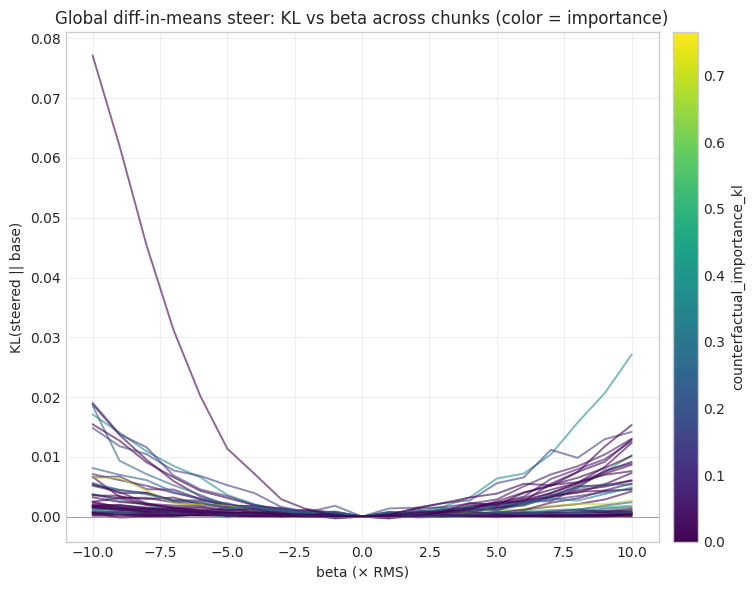

global_diff: n_points=46, spearman_rho=-0.02173796915406066, pval=0.8859794462108491, slope=-1.6871366228130773e-05, intercept=5.581620497508882e-05


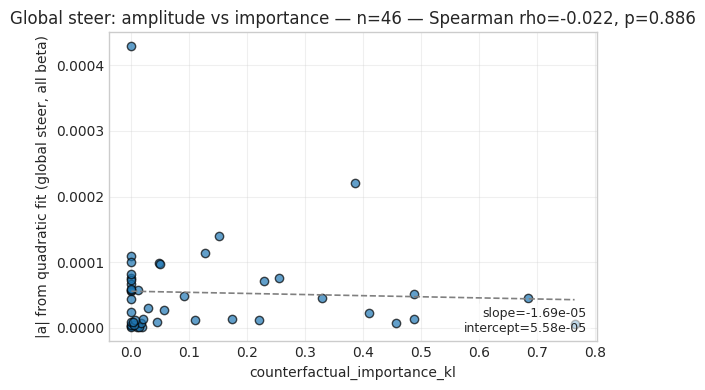

In [ ]:

# KL curves using the global difference-in-means vector, plus scatter amplitude vs importance
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
plt.style.use('seaborn-v0_8-whitegrid')

# Collect curves across examples/chunks using the single global vector
chunk_curves_globalvec = []
examples = [ex for ex in annotated if ex.get('thought_anchor_sentence')]
if max_examples is not None:
    examples = examples[:int(max_examples)]
examples_anchors = anchors_payload.get('examples', [])

for ex_i, ex in enumerate(examples):
    if ex_i >= len(examples_anchors):
        break
    anchors_ex = examples_anchors[ex_i] or {}
    layer_idx = anchors_ex.get('layer', model.config.num_hidden_layers - 1)
    # Prepare question and chunks
    question = ex.get('prompt', '')
    cot_text = ex.get('cot') or ''
    try:
        chunks = split_solution_into_chunks(cot_text)
    except Exception:
        import re
        chunks = [p.strip() for p in re.split(r'(?<=[\.\!\?])\s+|\n\n+', cot_text) if p.strip()]
    if not chunks:
        continue
    # Map the same vector to every chunk index
    chunk_vectors = {i: global_steer_vector for i in range(len(chunks))}
    # Compute KL curve for each chunk
    for idx in range(len(chunks)):
        curve = kl_curve_for_chunk(idx, betas)
        if not curve:
            continue
        imp = 0.0
        try:
            imp = float(ex.get('counterfactual_importance_kl', [0.0]*len(chunks))[idx])
        except Exception:
            pass
        chunk_curves_globalvec.append({'example_index': ex_i, 'chunk_index': idx, 'importance': imp, 'ys': list(map(float, curve))})

# Plot (i) KL curves vs beta, colored by importance
if chunk_curves_globalvec:
    imps = np.array([c['importance'] for c in chunk_curves_globalvec], dtype=float)
    imp_min = float(np.nanmin(imps)) if imps.size>0 else 0.0
    imp_max = float(np.nanmax(imps)) if imps.size>0 else 1.0
    if not np.isfinite(imp_min): imp_min = 0.0
    if not np.isfinite(imp_max) or imp_max <= imp_min: imp_max = imp_min + 1e-6
    norm = Normalize(vmin=imp_min, vmax=imp_max)
    cmap = plt.cm.viridis
    fig, ax = plt.subplots(figsize=(8,6))
    for c in chunk_curves_globalvec:
        ys = np.array(c['ys'], dtype=float)
        n = min(len(ys), len(betas))
        xs = np.array(betas)[:n]; ys = ys[:n]
        col = cmap(norm(float(c['importance'])))
        ax.plot(xs, ys, color=col, linewidth=1.4, alpha=0.6)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm); sm.set_array(imps)
    cbar = fig.colorbar(sm, ax=ax, pad=0.02); cbar.set_label('counterfactual_importance_kl')
    ax.axhline(0, color='gray', lw=0.5)
    ax.set_xlabel('beta (× RMS)'); ax.set_ylabel('KL(steered || base)')
    ax.set_title('Global diff-in-means steer: KL vs beta across chunks (color = importance)')
    ax.grid(True, alpha=0.3)
    plt.tight_layout(); plt.show()

# Plot (ii) amplitude scatter with Spearman stats
# Fit quadratics over all beta for each curve and scatter vs importance
try:
    from scipy.stats import spearmanr
    _have_scipy = True
except Exception:
    _have_scipy = False

amps = []; imps = []
B = np.array([float(e) for e in betas])
for c in chunk_curves_globalvec:
    ys = np.array(c['ys'], dtype=float)
    n = min(len(ys), len(B))
    x = B[:n]; y = ys[:n]
    if x.size < 3 or np.all(np.isnan(y)):
        continue
    try:
        a = float(np.polyfit(x, y, 2)[0])
        amps.append(abs(a)); imps.append(float(c['importance']))
    except Exception:
        continue

X = np.array(imps); Y = np.array(amps)
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(X, Y, edgecolor='black', alpha=0.7)
ax.set_xlabel('counterfactual_importance_kl')
ax.set_ylabel('|a| from quadratic fit (global steer, all beta)')

rho, pval = np.nan, np.nan
if X.size > 1:
    if _have_scipy:
        try:
            rho, pval = spearmanr(X, Y)
        except Exception:
            rho, pval = np.nan, np.nan
    else:
        def _ranks(arr):
            order = np.argsort(arr); r = np.empty_like(order, dtype=float)
            r[order] = np.arange(len(arr), dtype=float); return r
        try:
            rX = _ranks(X); rY = _ranks(Y)
            if np.nanstd(rX) == 0 or np.nanstd(rY) == 0:
                rho, pval = np.nan, np.nan
            else:
                rho = float(np.corrcoef(rX, rY)[0,1]); pval = np.nan
        except Exception:
            rho, pval = np.nan, np.nan

slope, intercept = np.nan, np.nan
if X.size > 1 and not np.allclose(X, X[0]):
    try:
        slope, intercept = np.polyfit(X, Y, 1)
        xs = np.linspace(np.nanmin(X), np.nanmax(X), 200)
        ax.plot(xs, slope*xs + intercept, color='gray', linestyle='--', linewidth=1.2)
    except Exception:
        slope, intercept = np.nan, np.nan

ax.set_title(f'Global steer: amplitude vs importance — n={X.size} — Spearman rho={np.nan if np.isnan(rho) else float(rho):.3f}' + ((f', p={float(pval):.3g}') if not np.isnan(pval) else ''))
if not np.isnan(slope) or not np.isnan(intercept):
    ax.text(0.98, 0.02, f'slope={slope:.3g}\nintercept={intercept:.3g}', transform=ax.transAxes, ha='right', va='bottom', fontsize=9,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.6, edgecolor='none'))
print(f'global_diff: n_points={X.size}, spearman_rho={rho}, pval={pval}, slope={slope}, intercept={intercept}')
ax.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

# Use this single global vector for subsequent KL curves
USE_CHUNK_VECTORS = False
steer_vector = global_steer_vector

